In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#This method allows Data Augmentation but should only be run on GPU
from keras.applications import VGG16
#Just reuse the bottom convolutional base of VGG16 model as its more generic, top will be related to specific classes so not used
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [23]:
#Adding a sequential model to top of conv_base
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

In [24]:
#freeze the conv base. Freezing a layer means preventing their weights from being updated during training
print('This is the number of trainable weights ''before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [25]:
train_dir="/content/drive/MyDrive/Driver_Distraction_Detection/train/"
validation_dir="/content/drive/MyDrive/Driver_Distraction_Detection/validation/"
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)

In [27]:
#Validation Data Set should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)
#Resize all images to 150x150
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),batch_size=32,class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
validation_dir,target_size=(150, 150),batch_size=32,class_mode='categorical')
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=2e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=150)

Found 10000 images belonging to 10 classes.
Found 4900 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 74s 732ms/step - loss: 2.3021 - acc: 0.9000 - val_loss: 2.3014 - val_acc: 0.9000
Epoch 2/30
100/100 [==============================] - 73s 737ms/step - loss: 2.2988 - acc: 0.9000 - val_loss: 2.2975 - val_acc: 0.9000
Epoch 3/30
100/100 [==============================] - 74s 741ms/step - loss: 2.2888 - acc: 0.9000 - val_loss: 2.2907 - val_acc: 0.9000
Epoch 4/30
100/100 [==============================] - 74s 739ms/step - loss: 2.2741 - acc: 0.9000 - val_loss: 2.2810 - val_acc: 0.9000
Epoch 5/30
100/100 [==============================] - 73s 737ms/step - loss: 2.2541 - acc: 0.9000 - val_loss: 2.2654 - val_acc: 0.9000
Epoch 6/30
100/100 [==============================] - 73s 733ms/step - loss: 2.2266 - acc: 0.9000 - val_loss: 2.2554 - val_acc: 0.9000
Epoch 7/30
100/100 [==============================] - 74s 740ms/step - loss: 2.1927 - acc: 0.9000 - val_loss: 2.2433 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 7

In [28]:
#Freezing all the layers except a specific one
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [29]:
#Fine Tuning the model
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-5),
metrics=['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=100,
validation_data=validation_generator,
validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 52s 511ms/step - loss: 1.3706 - acc: 0.9137 - val_loss: 2.4518 - val_acc: 0.8903
Epoch 2/100
100/100 [==============================] - 50s 501ms/step - loss: 1.1633 - acc: 0.9219 - val_loss: 2.0569 - val_acc: 0.8935
Epoch 3/100
100/100 [==============================] - 50s 500ms/step - loss: 0.9977 - acc: 0.9320 - val_loss: 2.8018 - val_acc: 0.8767
Epoch 4/100
100/100 [==============================] - 50s 504ms/step - loss: 0.9292 - acc: 0.9389 - val_loss: 2.2994 - val_acc: 0.8745
Epoch 5/100
100/100 [==============================] - 50s 501ms/step - loss: 0.8257 - acc: 0.9452 - val_loss: 1.9951 - val_acc: 0.8903
Epoch 6/100
100/100 [==============================] - 50s 499ms/step - loss: 0.7634 - acc: 0.9488 - val_loss: 2.0611 - val_acc: 0.8829
Epoch 7/100
100/100 [==============================] - 50s 499ms/step - loss: 0.7021 - acc: 0.9531 - val_loss: 2.2922 - val_acc: 0.8754
Epoch 8/100
100/100 [===========================

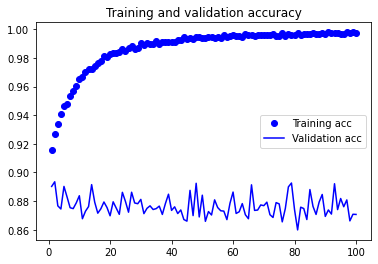

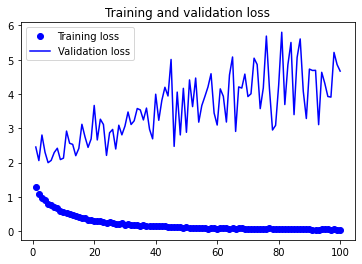

In [30]:
#Plotting the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()